In [118]:
%reset -f
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from sklearn.metrics import mean_squared_error

import arma_helper
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

data_train = arma_helper.load_data("data/BATADAL_dataset03.csv")
train_data, train_labels = arma_helper.pre_process(data_train)
data_test = arma_helper.load_data("data/BATADAL_test_dataset.csv")
test_data, test_labels = arma_helper.pre_process(data_test, test=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
for col in train_data.columns:
    column = train_data[col]
    print(col, np.mean(column), np.var(column))

L_T1 2.6769051164360236 1.446900216893852
L_T2 3.2857475107770804 2.156600792979255
L_T3 4.201820402627554 0.460262323652
L_T4 3.5681289083472207 0.2911949349089766
L_T5 2.7482054566631664 0.5404014179831003
L_T6 5.370436701486131 0.03148824144491118
L_T7 3.3026716895862345 0.6869124745678105
F_PU1 100.92603206129323 100.96320396929988
F_PU2 69.46435679759732 1783.992190980667
F_PU4 14.555019008551536 290.42336028128886
F_PU6 0.06700974111631092 2.4547862877973614
F_PU7 41.71393404291177 317.97347412860603
F_PU8 21.092608719732908 303.46491747805607
F_PU10 25.113332513919648 145.93319261674455
F_PU11 0.010239997690902865 0.2306820191942293
F_V2 56.465939073667386 1297.2489495866366
P_J280 2.9797734634314574 4.1415365765906396e-05
P_J269 32.369772264200435 30.872565731453395
P_J300 27.76645050921927 7.510878269133489
P_J256 79.41108216383746 71.59598569914374
P_J289 27.776600162225773 7.399137630304596
P_J415 82.73761539835635 56.28763094929872
P_J302 24.45380831415592 19.49961418743174

In [245]:
test_data.head()

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,F_PU3,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
0,0.73,2.27,4.00,3.26,3.87,5.50,4.28,98.93,98.95,0.0,...,26.68,90.54,26.74,84.52,19.43,83.27,19.33,71.33,29.61,28.71
1,0.69,2.25,4.53,3.26,3.84,5.50,4.78,97.95,97.97,0.0,...,26.67,90.43,26.73,85.04,25.97,64.22,25.86,73.79,29.63,28.73
2,0.90,2.31,5.03,3.41,3.32,5.16,3.22,96.82,96.84,0.0,...,26.83,91.72,26.89,87.16,29.18,63.81,29.18,59.05,29.80,28.90
3,1.11,2.54,5.16,3.97,2.82,5.01,2.54,96.76,96.78,0.0,...,28.27,76.12,28.23,88.83,26.53,63.42,26.41,70.92,30.80,29.90
4,1.27,2.99,4.94,4.27,2.35,5.38,3.41,94.77,94.79,0.0,...,31.32,75.68,31.32,69.55,27.46,63.43,27.34,70.88,33.61,32.71


Sensor L_T1


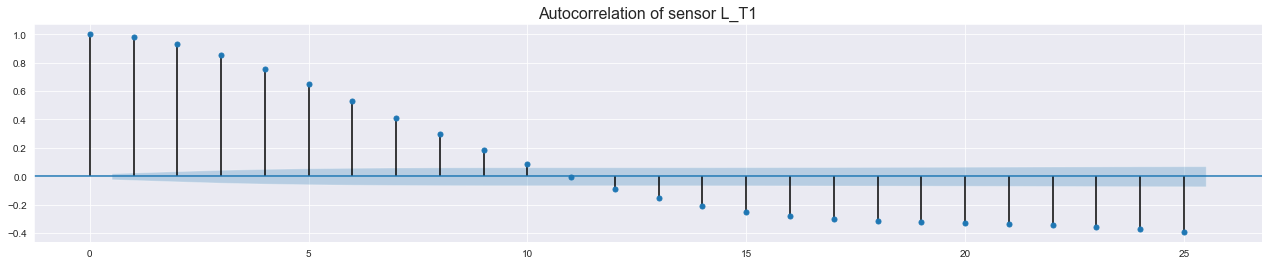

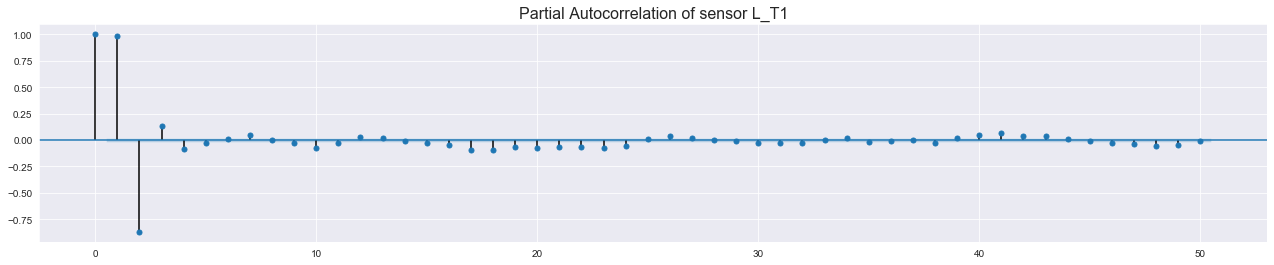

Sensor L_T2


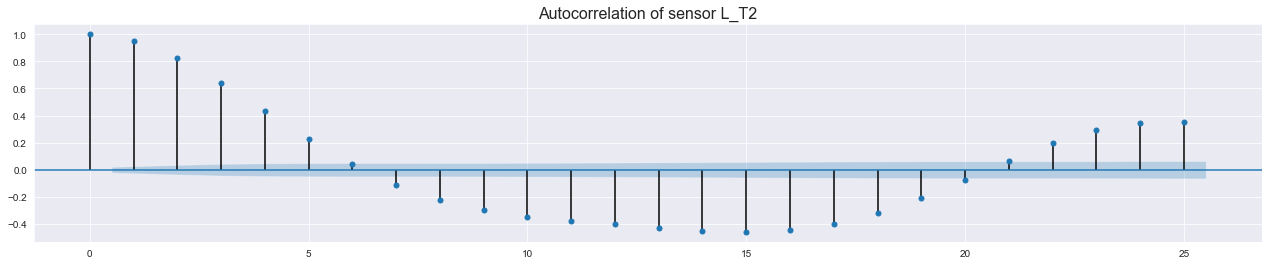

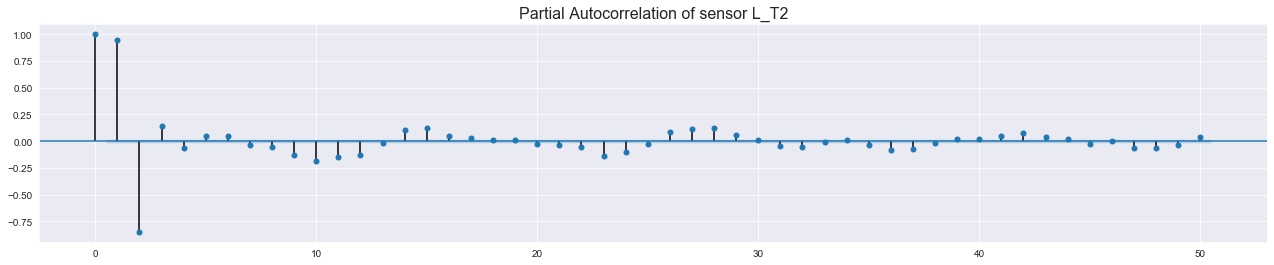

Sensor L_T3


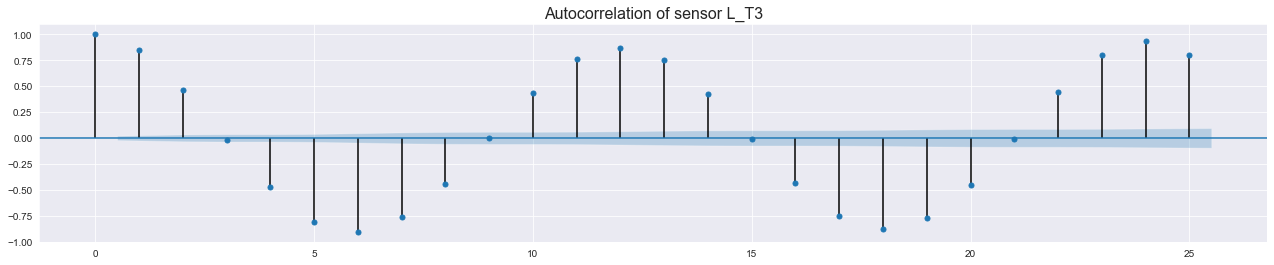

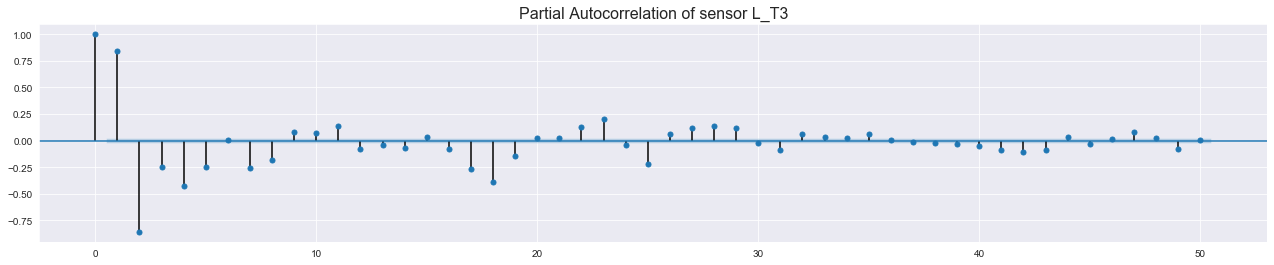

Sensor L_T4


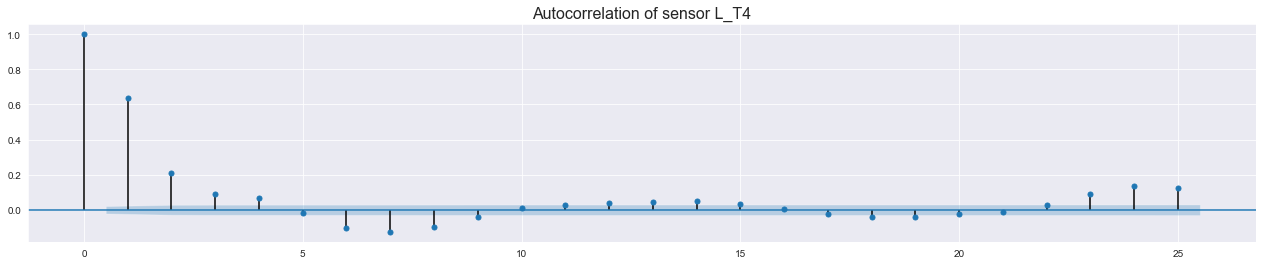

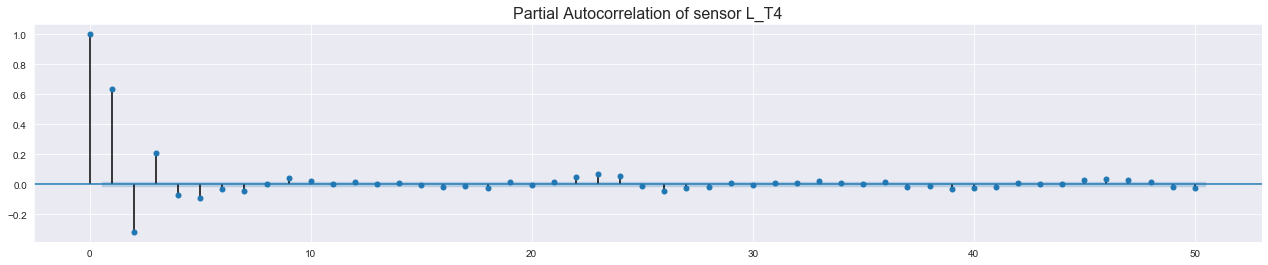

Sensor L_T5


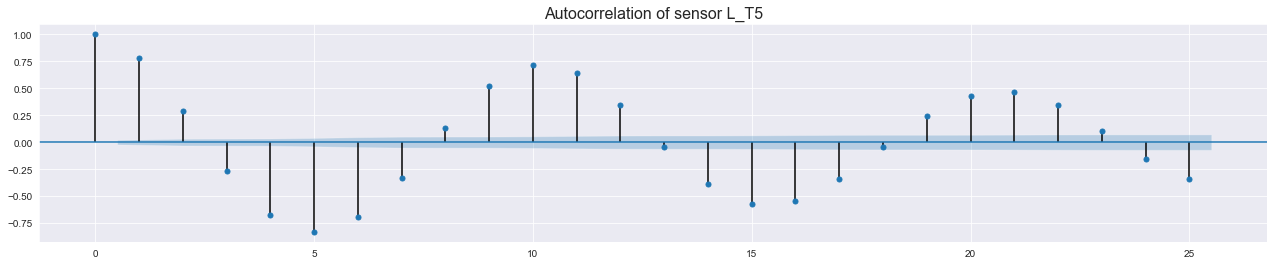

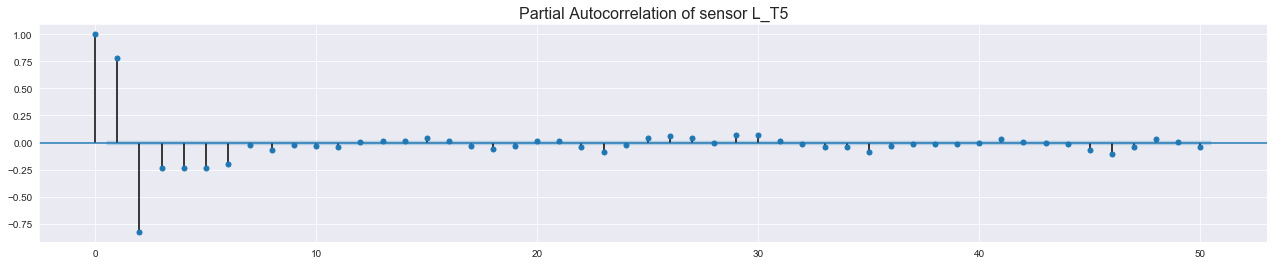

Sensor L_T6


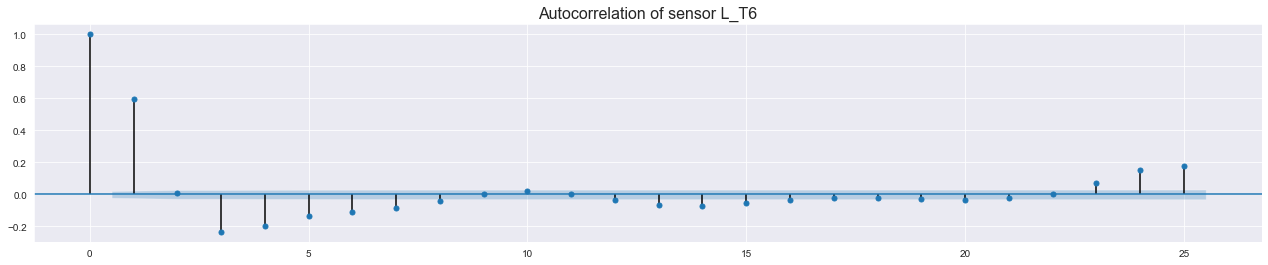

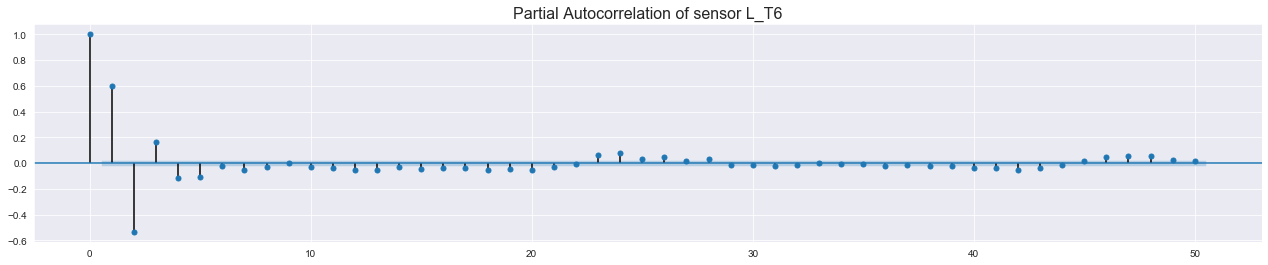

Sensor L_T7


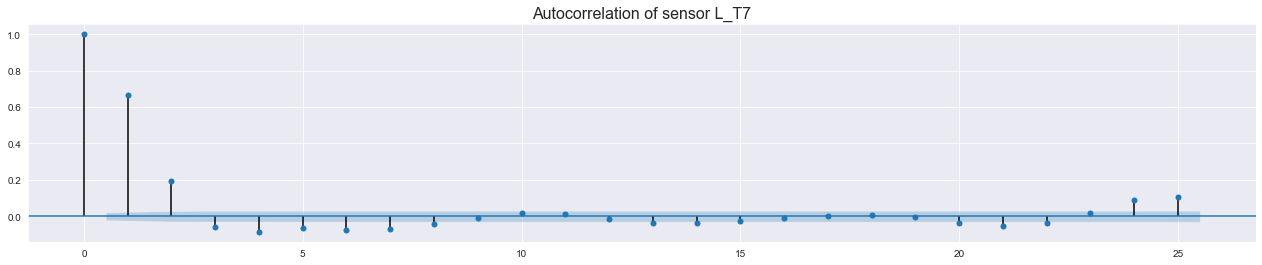

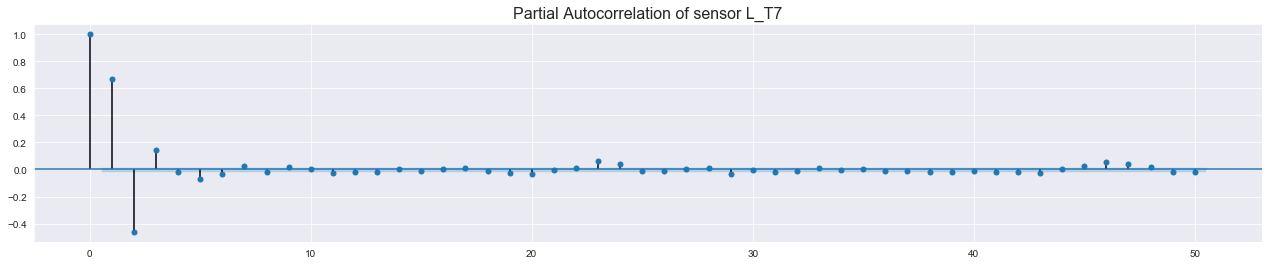

In [285]:
# The data is already processed
# Only observe the sensor signals (from the tanks)
# Before fitting an ARMA model we have to determine whether AR or MA terms are needed to correct any 
# autocorrelation that remains in the differenced series. This can be done with statsmodels package, but also by
# looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series.
# 

# sensors = ["L_T2","F_PU2","F_V2","P_J306"]
sensors = ["L_T1","L_T2","L_T3","L_T4","L_T5","L_T6","L_T7"]

for sensor in sensors:
    arma_helper.plot_autocorrelation(train_data[sensor], sensor)

In [243]:
# Determine optimal AR and MA parameters based on Akaike's Information Criterion (AIC)
# Processing takes several hours, only run if necessary
# p and q values are calculated to execute rest of task
compute_parameters = False

if compute_parameters == True:
    p = [1]*len(sensors)
    q = [0]*len(sensors)
    aic = [float('inf')]*len(sensors)
    params_AR = range(1,10)
    params_MA = range(0,10)

    for sensor in sensors:
        index = sensors.index(sensor)
        for i in params_AR:
            for j in params_MA:
                try:
                    aic_score = arma_helper.calculate_parameters(train_data[sensor],i,j)
                    if aic_score < aic[index]:
                        aic[index] = aic_score
                        p[index] = i
                        q[index] = j
                except: 
                    continue;

        print(sensor, p[index], q[index], aic[index])
else:
    # Tank signals
    p = [7, 7, 9, 3, 8, 9, 4]
    q = [7, 7, 9, 7, 9, 8, 7]
    
    # From each category one signas: ["L_T2","F_PU2","F_V2","P_J306"]
    p = [7, 4, 9, 8]
    q = [7, 8, 9, 9]

/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'avail

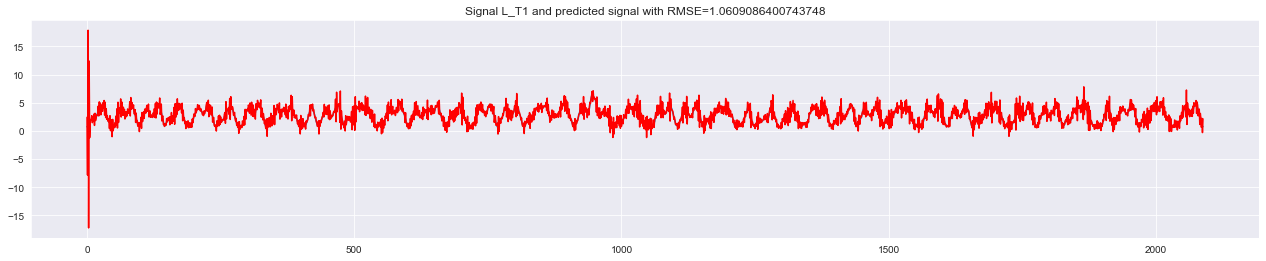

/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


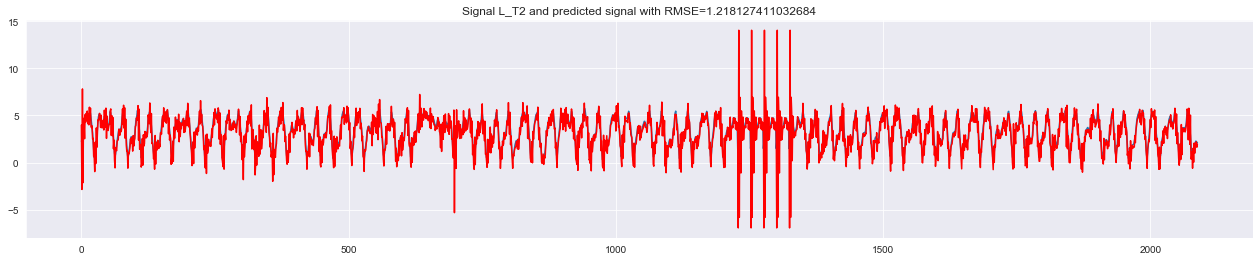

/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


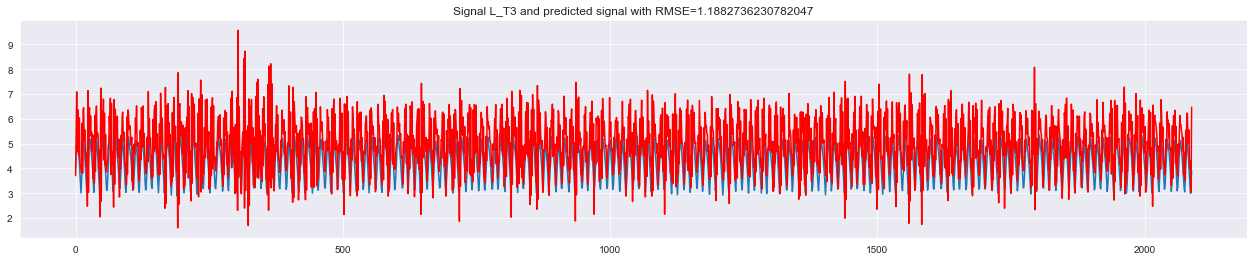

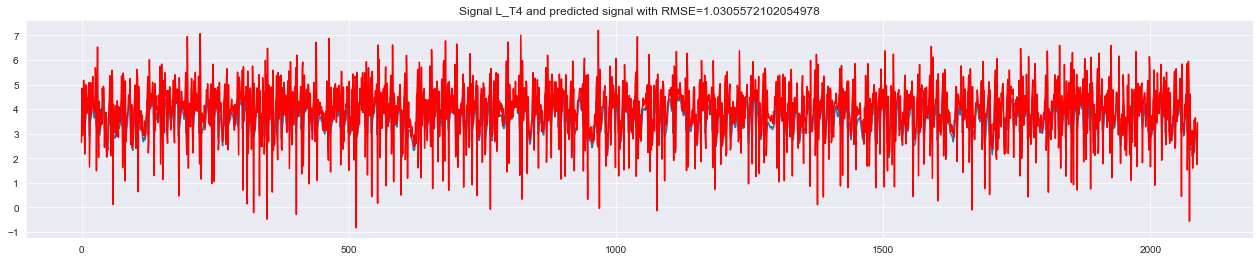

/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


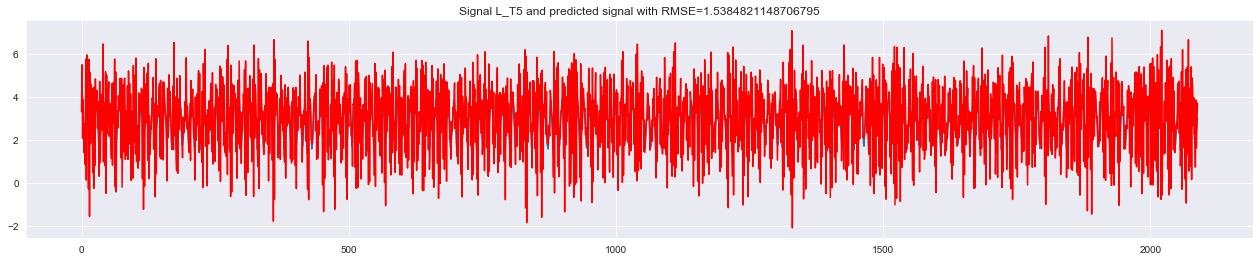

/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


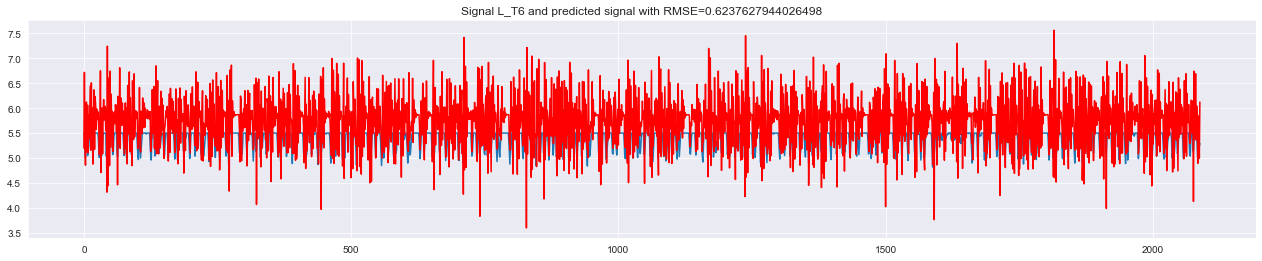

/Users/jbambacht/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


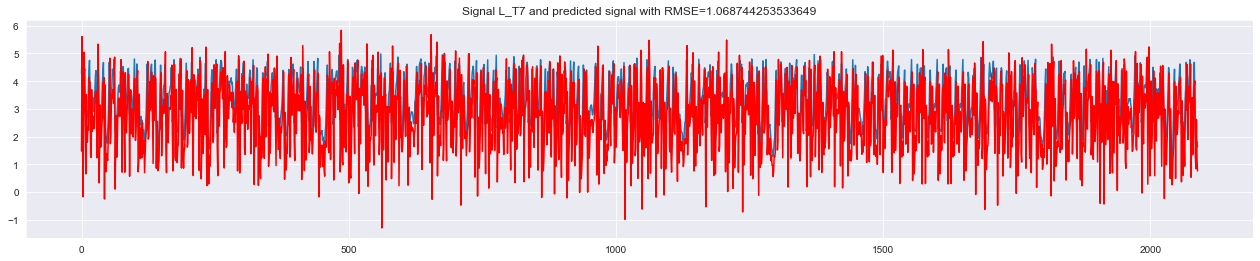

In [279]:
# Computed parameters for all tanks signals
# p = [7, 7, 9, 3, 8, 9, 4]
# q = [7, 7, 9, 7, 9, 8, 7]
# L_T1 7 7 -16891.57666656138
# L_T2 7 7 -1937.300859995401
# L_T3 9 9 -10566.014270195785
# L_T4 3 7 7869.872628503199
# L_T5 8 9 -1182.7290762813573
# L_T6 9 8 -13160.396504732827
# L_T7 4 7 13939.371246562932

# 
# F_V2 9 9 77325.15483794194
# F_PU2 4 8 75094.18221067122
# P_J306 8 9 56947.17608324569

test_sets = list()
prediction_sets = list()

# For each sensor we first train the model, based on the parameters calculated before, and all elements in the
# test set we are predicting the next value based on previous point, and equations of AR and MA.
# Afterwards we calculate the RMSE and plot the original and predicted signal in one figure for comparison
for sensor in sensors:
    index = sensors.index(sensor)
    test = test_data[sensor]
    history = [x for x in train_data[sensor]]
    predictions = list()

    # Train and fit the model using the parameters and train data, compute the residual and compute the AR
    # and MA coefficients, required for the prediction of the next point
    model = ARIMA(history, order=(p[index], 0, q[index]))
    model_fit = model.fit()
    resid = model_fit.resid
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams

    # For each sensor value in the test set we apply differencing on the sensor value and predict the next point
    # We add this predicted value to the set of predictions
    for i in range(len(test)):
        difference = arma_helper.difference(history)
        y_hat = history[-1]+arma_helper.predict(ar_coef, difference) + arma_helper.predict(ma_coef, resid)
        predictions.append(y_hat)
        observation = test.loc[i]
        history.append(observation)
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    
    # Add values to sets for later use
    test_sets.append(test)
    prediction_sets.append(predictions)
    
    # Plot the original and predicted signals for each sensor
    fig,ax = plt.subplots(figsize=(22,4))
    plt.plot(test_data[sensor])
    plt.plot(predictions, color='red')
    ax.set_title('Signal '+sensor+' and predicted signal with RMSE='+"{:.3f}".format(rmse),size=16)
    ax.legend(loc='upper right', labels=['Original signal','Predicted signal'])
    plt.show()

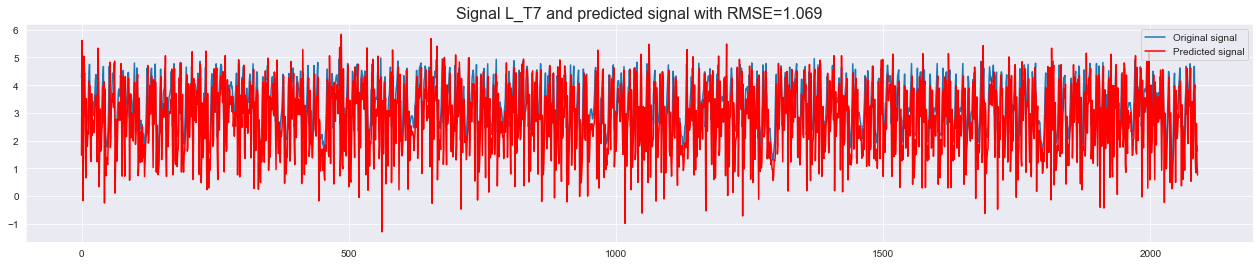

In [283]:
    fig,ax = plt.subplots(figsize=(22,4))
    plt.plot(test_data[sensor])
    plt.plot(predictions, color='red')
    ax.set_title('Signal '+sensor+' and predicted signal with RMSE='+"{:.3f}".format(rmse),size=16)
    ax.legend(loc='upper right', labels=['Original signal','Predicted signal'])
    plt.show()

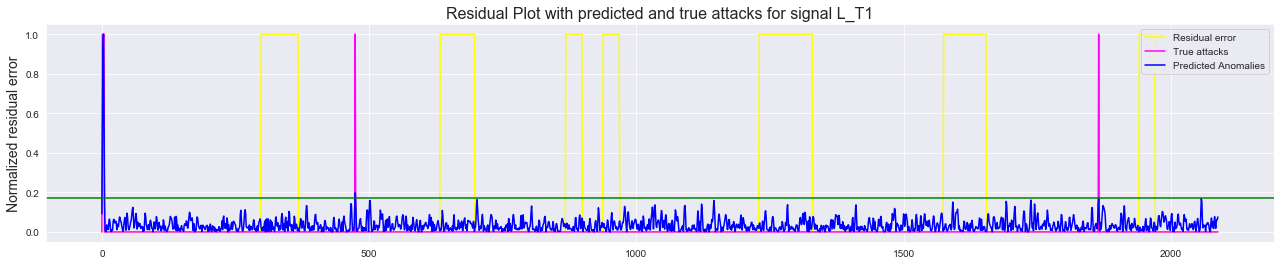

TP 0 FP 6 FN 407 TN 1676
Accuracy 0.8022977501196745
Precision 0.0
Recall 0.0
F1 0.0
ROC 0.4982164090368609


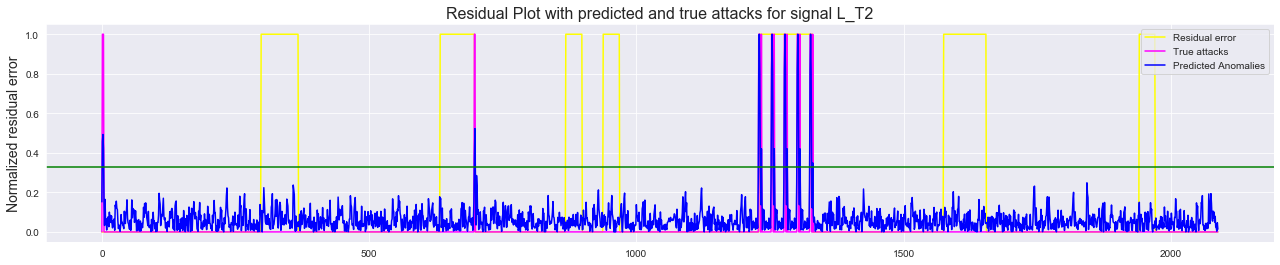

TP 19 FP 6 FN 388 TN 1676
Accuracy 0.8113930110100527
Precision 0.76
Recall 0.04668304668304668
F1 0.08796296296296295
ROC 0.5215579323783842


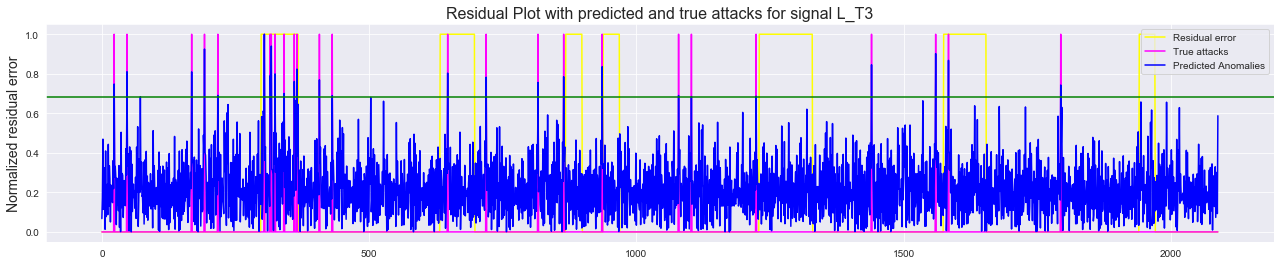

TP 9 FP 17 FN 398 TN 1665
Accuracy 0.8013403542364768
Precision 0.34615384615384615
Recall 0.022113022113022112
F1 0.04157043879907621
ROC 0.5060030033276169


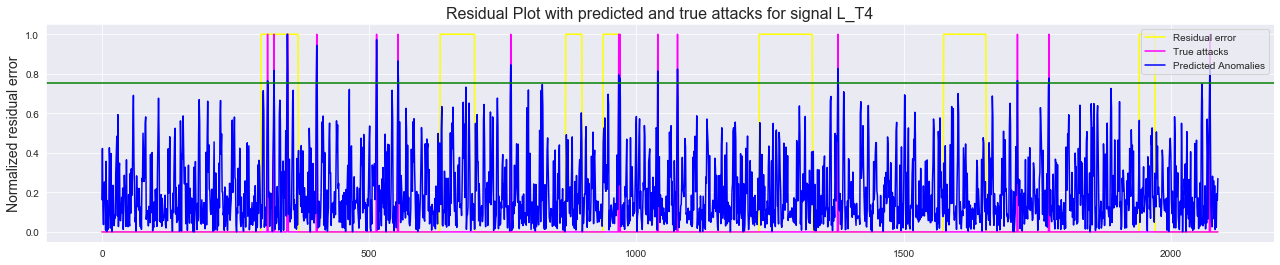

TP 5 FP 11 FN 402 TN 1671
Accuracy 0.8022977501196745
Precision 0.3125
Recall 0.012285012285012284
F1 0.02364066193853428
ROC 0.5028725893767511


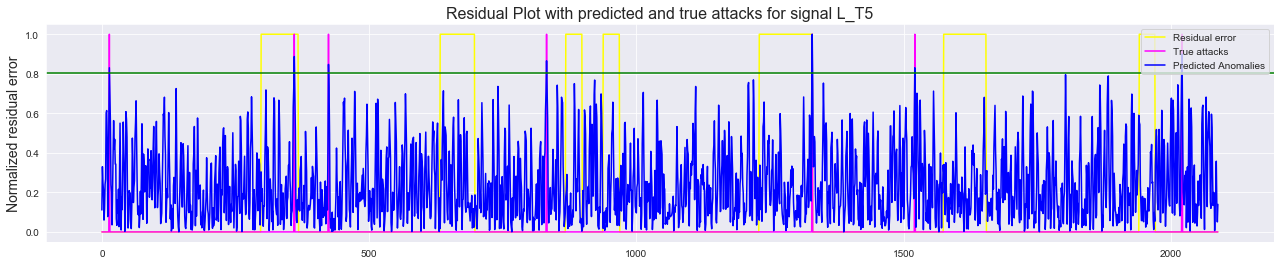

TP 2 FP 5 FN 405 TN 1677
Accuracy 0.803733843944471
Precision 0.2857142857142857
Recall 0.004914004914004914
F1 0.009661835748792272
ROC 0.5009706766543864


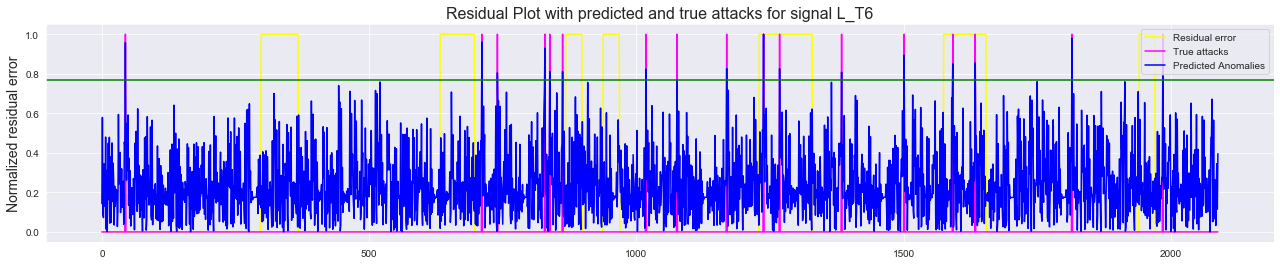

TP 4 FP 13 FN 403 TN 1669
Accuracy 0.8008616562948779
Precision 0.23529411764705882
Recall 0.009828009828009828
F1 0.018867924528301886
ROC 0.5010495578272035


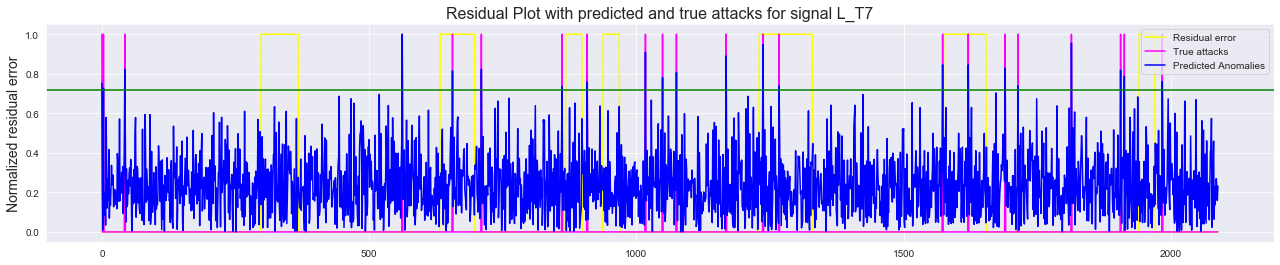

TP 4 FP 18 FN 403 TN 1664
Accuracy 0.7984681665868837
Precision 0.18181818181818182
Recall 0.009828009828009828
F1 0.018648018648018648
ROC 0.4995632320245876


In [291]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for i in range(len(sensors)):

    residual = abs(test_sets[i]-prediction_sets[i])
    residual = residual/max(residual)
    threshold = np.mean(residual)+3*np.std(residual)
    
    anomalies = [(x > threshold) for x in residual]
            
    tn, fp, fn, tp = confusion_matrix(test_labels, anomalies).ravel()
    accuracy = accuracy_score(test_labels, anomalies)
    precision = precision_score(test_labels, anomalies)
    recall = recall_score(test_labels, anomalies)
    f1 = f1_score(test_labels,anomalies)
    roc = roc_auc_score(test_labels,anomalies)
    
    fig,ax = plt.subplots(figsize=(22,4))
    
    plt.plot(test_labels, color='yellow')
    plt.plot(anomalies, color='magenta')
    plt.plot(residual, color='blue')
    plt.axhline(y=threshold, color='green')
    ax.set_title("Residual Plot with predicted and true attacks for signal "+sensors[i],size=16)
    ax.legend(loc='upper right', labels=['Residual error','True attacks','Predicted Anomalies'])
    ax.set_ylabel('Normalized residual error',size=14)
    plt.show()
    
    print('TP', tp, 'FP', fp, 'FN', fn, 'TN', tn)
    print('Accuracy', accuracy)
    print('Precision', precision)
    print('Recall', recall)
    print('F1', f1)
    print('ROC', roc)
    


In [299]:
np.abs(test_sets[0]-predictions[0])

0       0.742058
1       0.782058
2       0.572058
3       0.362058
4       0.202058
          ...   
2084    0.467942
2085    0.067942
2086    0.402058
2087    0.622058
2088    0.732058
Name: L_T1, Length: 2089, dtype: float64